# Example 3: Add on site SOC term to wannier90_hr of Na2TeCo2O6 system.

In [3]:
import numpy as np
from scipy.optimize import minimize
import numpy as np
from tbsoc.lib.lm_expand import MapLmSp, MapLpSm, MapLzSz
from tbsoc.lib.const import Mtrans
from tbsoc.lib.printmat import printsocmat
from tbsoc.lib.read_in import read_poscar_wan_in, read_hr,read_EIGENVAL,read_KPOINTS
from tbsoc.lib.soc_mat import creat_basis_lm,get_matrix_lmbasis,trans_lm_spatial,soc_order,get_mat_soc_orb,get_Hsoc
from tbsoc.lib.cal_tools import hr2hk
from tbsoc.lib.plot_tools import band_plot
from tbsoc.lib.write_hr import write_hr
import matplotlib.pyplot as plt
import time
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

### 1.  Initialization. read wannier90.win and POSCAR
**NOTE: Here for Na2TeCo2O6 only Co is projected on to get the wannier TB. Therefor the POSCAR should only keep the atoms coordinates of the Co atoms.**


In [4]:
workdir='./'
## read poscar and projection infomations
Lattice, atoms, atom_proj, orbitals, orb_num, orb_type = \
        read_poscar_wan_in(poscarfile = workdir + 'POSCAR',waninfile = workdir+'wannier90.win')


## based the projection, build the soc matrix.
Msoc={}
for orb in np.unique(orbitals):
    Msoc_orb = get_mat_soc_orb(orb)
    Msoc[orb] = Msoc_orb

num_interaction = len(np.unique(orb_type))
print(u'number of lambda of soc is %d' %num_interaction)

reading POSCAR ...
successfully reading POSCAR ...
reading wannier90.win ...
successfully reading wannier90.win ...
The projections is :
Co 	d 	
Co 	d 	
Co 	d 	
Co 	d 	
generating Hsoc mat for dorbital in atomic orbital basis
   0.00    0.00    0.00   -1.73    0.00    1.73I   0.00    0.00    0.00    0.00 

   0.00    0.00    1.73    0.00    1.73I   0.00    0.00    0.00    0.00    0.00 

   0.00    1.73    0.00    0.00   -1.00I   0.00    0.00   -1.00    0.00    1.00I

  -1.73    0.00    0.00    0.00    0.00    1.00I   1.00    0.00    1.00I   0.00 

   0.00   -1.73I   1.00I   0.00    0.00    0.00    0.00   -1.00I   0.00   -1.00 

  -1.73I   0.00    0.00   -1.00I   0.00    0.00   -1.00I   0.00    1.00    0.00 

   0.00    0.00    0.00    1.00    0.00    1.00I   0.00    0.00   -2.00I   0.00 

   0.00    0.00   -1.00    0.00    1.00I   0.00    0.00    0.00    0.00    2.00I

   0.00    0.00    0.00   -1.00I   0.00    1.00    2.00I   0.00    0.00    0.00 

   0.00    0.00   -1.00I   0.00   -1

In [5]:
## read non soc hopping files, and make it spinor,withform
#[ H   0]
#[ 0   H]
hop_spinor, Rlatt, indR0 = read_hr(workdir+'wannier90_hr.dat')
nrpts = hop_spinor.shape[0]
num_wan = 2 * np.sum(orb_num)
if num_wan!=hop_spinor.shape[1]:
    print ("number of wannier orbitals is wrong!")
    exit()

reading wannier90_hr.dat ...
successfully reading wannier90_hr.dat ...


In [6]:
## build the [num_wan,num_wan] dimension H_soc matrix. for given interaction strength
lambdas=[0.0621]
Hsoc = get_Hsoc(lambdas,orbitals,orb_type,orb_num,Msoc)

In [7]:
hop_soc = hop_spinor * 1.0
hop_soc[indR0] += Hsoc
kpath, xpath, xsymm, plot_sbol = read_KPOINTS(Lattice, kpofile = workdir+'KPOINTS')
Hksoc=hr2hk(hop_soc,Rlatt,kpath,num_wan)
bandsoc = np.linalg.eigvalsh(Hksoc)

reading KPOINTS ...
E : [   0.333,   0.333,   0.000] ===>  G : [   0.000,   0.000,   0.000]
G : [   0.000,   0.000,   0.000] ===>  S : [   0.000,   0.500,   0.000]
S : [   0.000,   0.500,   0.000] ===>  R : [   0.000,   0.500,   0.500]
R : [   0.000,   0.500,   0.500] ===>  Z : [   0.000,   0.000,   0.500]
Z : [   0.000,   0.000,   0.500] ===>  T : [  -0.500,   0.500,   0.500]
T : [  -0.500,   0.500,   0.500] ===>  Y : [  -0.500,   0.500,   0.000]
Y : [  -0.500,   0.500,   0.000] ===>  C : [  -0.333,   0.667,   0.000]
successfully reading KPOINTS ...


In [8]:
vasp_bands, vasp_kps = read_EIGENVAL(FILENAME=workdir+'EIGENVAL')

reading EIGENVAL ...
successfully reading EIGENVAL ...


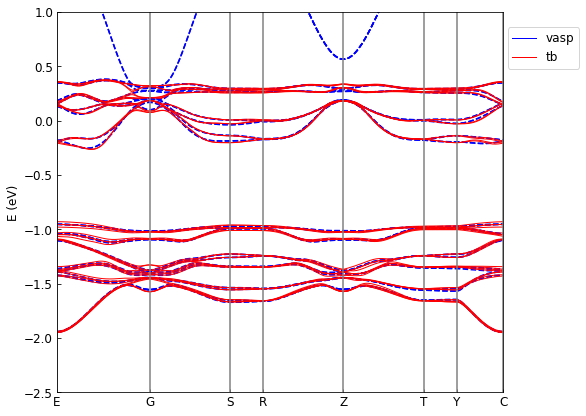

0

In [9]:
#Hknsoc=hr2hk(hop_spinor,Rlatt,kpath,num_wan)
#bandnsoc = np.linalg.eigvalsh(Hknsoc)

EMIN=-2.5
EMAX=1.0
Efermi=5.862
#band_plot(Efermi, EMIN, EMAX, xpath, xsymm, plot_sbol, bandnsoc, pl_tb=True, pl_vasp=False, bndvasp=0)
band_plot(Efermi, EMIN, EMAX, xpath, xsymm, plot_sbol, bandsoc, pl_tb=True,
          pl_vasp=True, bndvasp=vasp_bands,savedir=workdir)


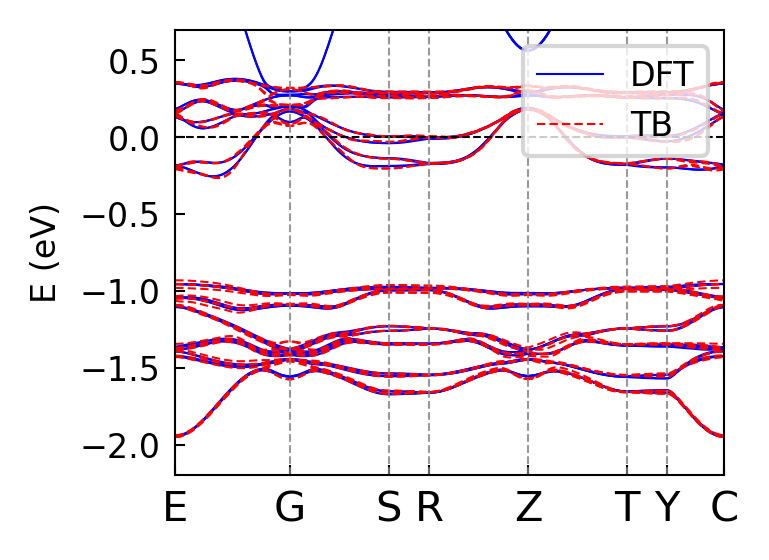

In [105]:
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
lws=0.5
fonts=8
Efermi=5.862
plt.figure(figsize=(6*0.3937,5*0.3937),dpi=300)
plt.plot(xpath,vasp_bands-Efermi,'b-',lw=lws)
plt.plot(xpath,vasp_bands[:,0]-Efermi,'b-',lw=lws,label='DFT')
plt.plot(xpath,bandsoc-Efermi,'r--',lw=lws,dashes=(4, 2))
plt.plot(xpath,bandsoc[:,0]-Efermi,'r--',lw=lws,dashes=(4, 2),label='TB')

plt.axhline(0,ls='--',lw=lws,c='k')
for ix in xsymm:
    plt.axvline(ix,ls='--',lw=lws,c='gray',alpha=0.8)
plt.xticks(xsymm,plot_sbol)
plt.xlim(xpath[0],xpath[-1])
plt.ylim(-2.2,0.7)
plt.legend(loc=1, fontsize=fonts)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5],fontsize=fonts)
plt.yticks(fontsize=fonts)
plt.tick_params(direction='in',length=2.5, width=lws)
plt.ylabel('E (eV)',fontsize=fonts)
#plt.savefig('./band_soc.pdf')
plt.show()

In [11]:
## define a objective function to be optimized.
## here we must know the which band in vasp_bands corresponding to which band in tb_bands
## thus this part is much ad hoc. i just put is here.
## before optimization, we should give a good initial guess of the lambdas. otherwise, the 
## optimization will be much time consuming.

def creat_hsoc(lambdas):
    #lambdas=[0.2,0.1]
    Hsoc = get_Hsoc(lambdas,orbitals,orb_type,orb_num,Msoc)
    
    hop_soc = hop_spinor * 1.0
    hop_soc[indR0] += Hsoc
    #kpath, xpath, xsymm, plot_sbol = read_KPOINTS(Lattice, kpofile = workdir+'KPOINTS')
    Hksoc=hr2hk(hop_soc,Rlatt,kpath,num_wan)
    bandsoc = np.linalg.eigvalsh(Hksoc)

    #picktb = bandsoc[:,0+20:40] * 1.0
    picktb = bandsoc[:,0+0:40] * 1.0
    picktb = picktb - np.average(picktb)
    #pickvasp = vasp_bands[:,8+20:8+40] * 1.0
    pickvasp = vasp_bands[:,120+0:120+40] * 1.0
    pickvasp = pickvasp - np.average(pickvasp)
    return np.sqrt(np.average((picktb - pickvasp)**2))

In [12]:
vasp_bands.shape

(350, 176)

In [13]:
# initial guess.
lambdas0 = [0.050]
err = creat_hsoc(lambdas0)
print('initial err is: %10.5f' %err)

res = minimize(creat_hsoc, lambdas0, method='nelder-mead',\
    options={'maxiter':50,'fatol':1e-2,'fatol': 1e-3, 'disp': True})

initial err is:    0.01000
Optimization terminated successfully.
         Current function value: 0.009643
         Iterations: 9
         Function evaluations: 18


In [15]:
res

 final_simplex: (array([[0.06210938],
       [0.06203125]]), array([0.00964289, 0.00964289]))
           fun: 0.009642891650814424
       message: 'Optimization terminated successfully.'
          nfev: 18
           nit: 9
        status: 0
       success: True
             x: array([0.06210938])

### write the soc hr file

In [ ]:
# write_hr(workdir,hop_soc,Rlatt)